In [1]:
import time
import pandas as pd
import numpy as np
import vaex

from vaex.ml.sklearn import IncrementalPredictor
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from dask_ml.wrappers import ParallelPostFit

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

In [2]:
%%time
df = pd.read_csv('../data/balanced_data.csv').sample(n=150000, axis=0)
df.tail()

CPU times: user 6.56 s, sys: 1.51 s, total: 8.07 s
Wall time: 8.07 s


,short_descriptions,assignment_groups
5077758,activate archive online,G SNOW EXT ATOS IS MAILING ADMINS
14164101,access,Service Now Support
4016362,derivations hungary re ritm0958139 routing sales,G SNOW EXT ATOS DATA MANAGEMENT AUTOMATION
6516872,NaN,G SNOW EXT ATOS SS HELPDESK
11113981,NaN,IOS - Telephony


In [3]:
# %%time
# df = vaex.from_pandas(df)

In [4]:
df.isna().sum() / len(df) * 100

short_descriptions    21.451333
assignment_groups      0.000000
dtype: float64

In [5]:
df.fillna('', inplace=True)

In [6]:
# temp = df.loc[df['short_descriptions'].str.len() == 20]

In [7]:
# temp.shape

<AxesSubplot:>

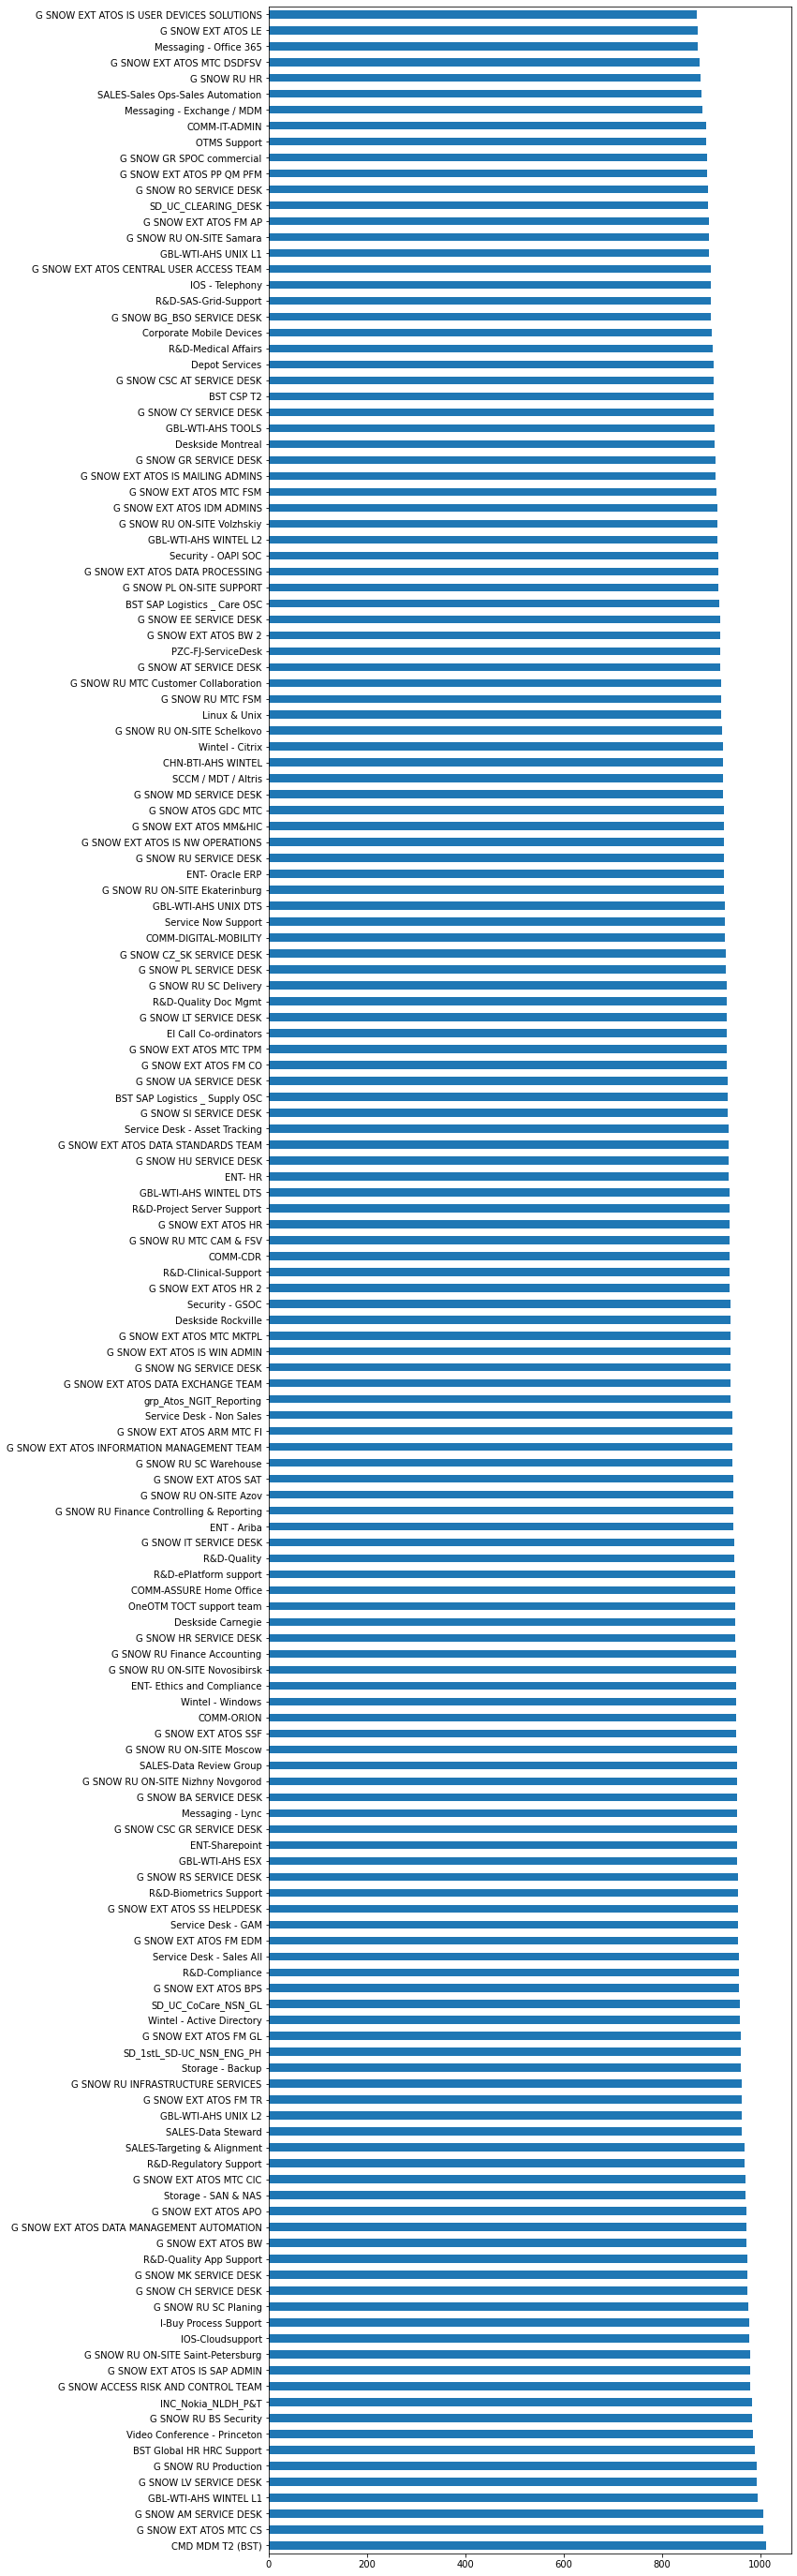

In [8]:
df['assignment_groups'].value_counts().plot(kind='barh', figsize=(10, 50))

In [9]:
X = df['short_descriptions'].values
y = df['assignment_groups'].values

In [10]:
X

array(['', 'approval list master re request', 'csp lt to', ...,
       'derivations hungary re ritm0958139 routing sales', '', ''],
      dtype=object)

In [11]:
y

array(['SALES-Targeting & Alignment', 'R&D-Clinical-Support',
       'BST CSP T2', ..., 'G SNOW EXT ATOS DATA MANAGEMENT AUTOMATION',
       'G SNOW EXT ATOS SS HELPDESK', 'IOS - Telephony'], dtype=object)

In [12]:
cnt_vec = CountVectorizer()
le = LabelEncoder()

In [13]:
%%time
X = cnt_vec.fit_transform(X)

CPU times: user 704 ms, sys: 0 ns, total: 704 ms
Wall time: 699 ms


In [14]:
%%time
y = le.fit_transform(y.astype(str))

CPU times: user 144 ms, sys: 0 ns, total: 144 ms
Wall time: 144 ms


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [16]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(135000, 5845) (135000,) (15000, 5845) (15000,)


In [21]:
models = [
    MultinomialNB(),
    LogisticRegression(n_jobs=-1, max_iter=150),
    RandomForestClassifier(n_jobs=-1),
    LinearSVC(),
    XGBClassifier(n_jobs=-1),
    DecisionTreeClassifier()
]


def display_metrics(true, pred):
    f1 = round(f1_score(y_true=true, y_pred=pred, average='weighted') * 100, 2)
    precision = round(precision_score(y_true=true, y_pred=pred, average='weighted') * 100, 2)
    recall = round(recall_score(y_true=true, y_pred=pred, average='weighted') * 100, 2)
    acc = round(accuracy_score(y_true=y_test, y_pred=preds) * 100, 2)

    print(f'Acc: {acc}')
    print(f'F1: {f1}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')

In [22]:
%%time

trained_models = dict()

for model in models:
    print(f'Training -> {model.__class__.__name__}')
    s = time.time()
    
    trained_models[model.__class__.__name__] = ParallelPostFit(
       estimator=model
    )
    
    trained_models[model.__class__.__name__].fit(X_train, y_train)
    
    e = time.time()
    
    preds = trained_models[model.__class__.__name__].predict(X_test)
    display_metrics(true=y_test, pred=preds)
    
    print(f'Training time: {round(e -s)} seconds')
    print('-' * 10)

INFO:MainThread:dask_ml.wrappers:Starting fit
INFO:MainThread:dask_ml.wrappers:Starting fit


Training -> MultinomialNB


INFO:MainThread:dask_ml.wrappers:Finished fit in 0:00:00.263262
INFO:MainThread:dask_ml.wrappers:Starting fit
INFO:MainThread:dask_ml.wrappers:Starting fit


Acc: 52.96
F1: 56.72
Precision: 72.25
Recall: 52.96
Training time: 0 seconds
----------
Training -> LogisticRegression


INFO:MainThread:dask_ml.wrappers:Finished fit in 0:03:57.304308
INFO:MainThread:dask_ml.wrappers:Starting fit
INFO:MainThread:dask_ml.wrappers:Starting fit


Acc: 57.86
F1: 63.28
Precision: 76.33
Recall: 57.86
Training time: 237 seconds
----------
Training -> RandomForestClassifier


INFO:MainThread:dask_ml.wrappers:Finished fit in 0:00:48.936875
INFO:MainThread:dask_ml.wrappers:Starting fit
INFO:MainThread:dask_ml.wrappers:Starting fit


Acc: 60.35
F1: 66.38
Precision: 80.22
Recall: 60.35
Training time: 49 seconds
----------
Training -> LinearSVC


INFO:MainThread:dask_ml.wrappers:Finished fit in 0:02:39.217328
INFO:MainThread:dask_ml.wrappers:Starting fit
INFO:MainThread:dask_ml.wrappers:Starting fit


Acc: 57.97
F1: 63.43
Precision: 77.08
Recall: 57.97
Training time: 159 seconds
----------
Training -> XGBClassifier


INFO:MainThread:dask_ml.wrappers:Finished fit in 0:16:27.002390
INFO:MainThread:dask_ml.wrappers:Starting fit
INFO:MainThread:dask_ml.wrappers:Starting fit


Acc: 57.32
F1: 63.17
Precision: 77.21
Recall: 57.32
Training time: 987 seconds
----------
Training -> DecisionTreeClassifier


INFO:MainThread:dask_ml.wrappers:Finished fit in 0:00:05.041505


Acc: 59.87
F1: 65.87
Precision: 79.68
Recall: 59.87
Training time: 5 seconds
----------
CPU times: user 28min 5s, sys: 4.78 s, total: 28min 10s
Wall time: 26min 33s


In [23]:
X_org = df['short_descriptions']
y_org = df['assignment_groups']

In [29]:
vectorizer = joblib.load(filename='../models/vectorizer.pkl')
encoder = joblib.load(filename='../models/encoder.pkl')

In [25]:
X_org_vec = cnt_vec.transform(X_org)
y_org_enc = le.transform(y_org)

In [26]:
preds = trained_models['RandomForestClassifier'].predict(X_org_vec)

In [27]:
accuracy_score(y_true=y_org_enc, y_pred=preds)

0.62742

In [28]:
f1_score(y_true=y_org_enc, y_pred=preds, average='weighted')

0.6916046728829847

In [29]:
precision_score(y_true=y_org_enc, y_pred=preds, average='weighted')

0.8304743379184266

In [30]:
recall_score(y_true=y_org_enc, y_pred=preds, average='weighted')

0.62742

In [31]:
import joblib

In [32]:
joblib.dump(trained_models['RandomForestClassifier'], '../models/randomforest', compress=2)

['../models/randomforest']